# Unsupervised Clustering - RFM Online Retail

## Table of Contents
- [Data Overview  and Preparation](#Data-Overview-and-Preparation)
- [RFM Analysis](#RFM-Analysis)
- [Model Building](#Model-Building)
- [Business Insights and Recommendations](#Business-Insights-and-Recommendations)

## Introduction

This project uses a dataset sourced from [UCI](https://archive.ics.uci.edu/dataset/352/online+retail).

## Dataset Overview
This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

* **InvoiceNo**:	a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation
* **StockCode**:	a 5-digit integral number uniquely assigned to each distinct product
* **Description**:	product name
* **Quantity**:		the quantities of each product (item) per transaction
* **InvoiceDate**:	the day and time when each transaction was generated
* **UnitPrice**:	product price per unit	sterling
* **CustomerID**:	a 5-digit integral number uniquely assigned to each customer
* **Country**:		the name of the country where each customer resides

## Objective
To segment customers based on purchasing behavior using Recency, Frequency, and Monetary (RFM) analysis combined with an unsupervised learning algorithm (KMeans). 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

from sklearn.neighbors import NearestNeighbors

pd.set_option("display.max_columns", None)
plt.rcParams['figure.dpi'] = 75

from IPython.display import display, HTML
display(HTML("<style>.container {width:100% !important}</style>"))

In [2]:
data = pd.read_csv('../data/Online Retail.csv', encoding='unicode_escape')
df = data.copy()

## Data Overview and Preparation

In [3]:
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.describe().round()

,Quantity,UnitPrice,CustomerID
count,541909.0,541909.0,406829.0
mean,10.0,5.0,15288.0
std,218.0,97.0,1714.0
min,-80995.0,-11062.0,12346.0
25%,1.0,1.0,13953.0
50%,3.0,2.0,15152.0
75%,10.0,4.0,16791.0
max,80995.0,38970.0,18287.0


In [6]:
df.describe(include='object')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


In [7]:
(df.Country.value_counts(1).round(3) * 100).head(10)

Country
United Kingdom    91.4
Germany            1.8
France             1.6
EIRE               1.5
Spain              0.5
Netherlands        0.4
Belgium            0.4
Switzerland        0.4
Portugal           0.3
Australia          0.2
Name: proportion, dtype: float64

In [8]:
# Dropping nulls
df = df.dropna()
df.shape

(406829, 8)

In [9]:
# Excluding negative quantity
df = df[df['Quantity'] >= 0]
df.shape

(397924, 8)

In [10]:
# Dropping dupes
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)
df.shape

(392732, 8)

In [11]:
# Convert InvoiceDate to InvoiceDatetime and remove hours and minutes
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = df['InvoiceDate'].dt.normalize()

In [12]:
# Adding sales column before aggregating
df['sales'] = df['UnitPrice'] * df['Quantity']

# Convert CustomerID to string before aggregating
df['CustomerID'] = df['CustomerID'].astype('str')
df['CustomerID'] = df['CustomerID'].str.rstrip('0.')

In [13]:
# Aggregate by date and exclude price since addition of sales column
grouped = df.select_dtypes(exclude=np.number).drop_duplicates()
grouped = grouped.columns.tolist()
df = df.groupby(grouped)[['Quantity', 'sales']].sum().reset_index()
print(df.shape)
df.head()

(387877, 8)


,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country,Quantity,sales
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01,1785,United Kingdom,6,25.50
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01,1785,United Kingdom,2,15.30
2,536365,71053,WHITE METAL LANTERN,2010-12-01,1785,United Kingdom,6,20.34
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01,1785,United Kingdom,6,20.34
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01,1785,United Kingdom,6,20.34


## Exploratory Data Analysis

What do sales and units look like over time?

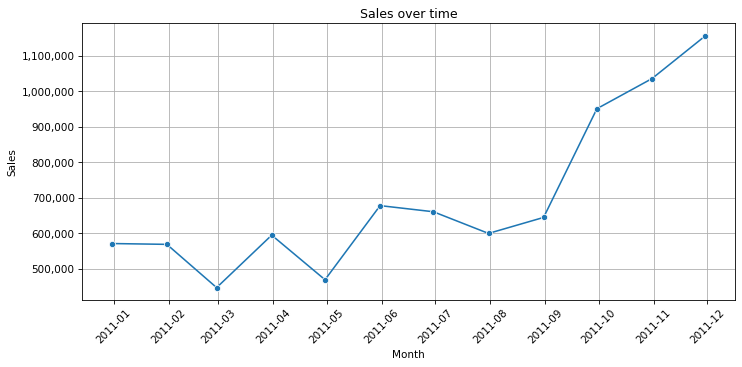

In [14]:
# Function to format y-axis without scientific notation
def human_format(x, pos):
    return f'{int(x):,}'

# date lineplot
monthly_data = df[['InvoiceDate', 'Quantity', 'sales']].resample('ME', on='InvoiceDate').sum().reset_index()
monthly_data = monthly_data[:-1]

plt.figure(figsize=(10, 5))
sns.lineplot(x='InvoiceDate', y='sales', data=monthly_data, marker='o')

# Set major locator to month and formatter to show month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Remove scientific notation on y-axis labels
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))

plt.title('Sales over time')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

Sales dropped over the first two months from January to March, then again in May but began to climb to more than double by the end of the year

## RFM Analysis

**Recency:** days since last customer transaction  
**Frequency:** number of transactions in the last 12 months  
**Monetary Value:** total spend in the last 12 months

In [15]:
# Calculate the day following the last invoice date for use in the Recency calculation
latest_day = max(df.InvoiceDate) + dt.timedelta(days=1)

# Calculate Recency, Frequency and Monetary value for each customer 
rfm = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (latest_day - x.max()).days,
    'InvoiceNo': 'count',
    'sales': 'sum'})

# Rename columns
rfm.rename(columns = {'InvoiceDate': 'Recency',
                      'InvoiceNo': 'Frequency',
                      'sales': 'Monetary'}, inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,3,182,4310.00
12348,76,27,1797.24
12349,19,73,1757.55
1235,311,17,334.40


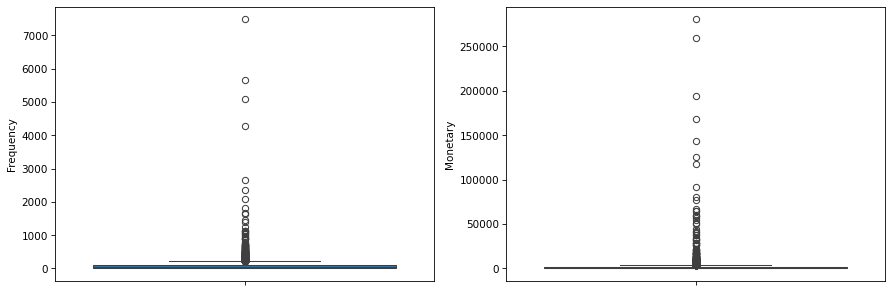

In [16]:
# Visualizing outliers
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); sns.boxplot(rfm['Frequency'])
plt.subplot(1, 2, 2); sns.boxplot(rfm['Monetary'])
plt.tight_layout()
plt.show()

In [17]:
# Calculating RFM score

# Setting weights for score calculations of each R, F, and M
recency_weight = 0.2
frequency_weight = 0.4
monetary_weight = 0.4

# Higher rank for recency is better, since it will be divided by the max rank and give it a greater score if the recency is low
rfm['Recency_Rank'] = rfm['Recency'].rank(ascending=False)
rfm['Frequency_Rank'] = rfm['Frequency'].rank(ascending=True)
rfm['Monetary_Rank'] = rfm['Monetary'].rank(ascending=True)

# Normalize ranks by the highest rank and scale to 100
rfm['Recency_Score'] = (rfm['Recency_Rank'] / rfm['Recency_Rank'].max()) * 100
rfm['Frequency_Score'] = (rfm['Frequency_Rank'] / rfm['Frequency_Rank'].max()) * 100
rfm['Monetary_Score'] = (rfm['Monetary_Rank'] / rfm['Monetary_Rank'].max()) * 100

# Calculate the final RFM score using the given weights
rfm['RFM_Score'] = ((rfm['Recency_Score'] * recency_weight) +
                    (rfm['Frequency_Score'] * frequency_weight) +
                    (rfm['Monetary_Score'] * monetary_weight))

# Scale the final RFM score to be between 0 and 5
rfm['RFM_Score'] = (rfm['RFM_Score'] / 100) * 5

rfm[['Recency', 'Frequency', 'Monetary', 'Recency_Score', 'Frequency_Score', 'Monetary_Score', 'RFM_Score']].head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
CustomerID,,,,,,,
12346,326,1,77183.60,3.759833,0.852731,99.792579,2.050505
12347,3,182,4310.00,96.170754,88.315280,92.302374,4.574061
12348,76,27,1797.24,38.084220,37.508643,76.884075,2.668697
12349,19,73,1757.55,74.259602,67.434893,76.353999,3.618374
1235,311,17,334.40,5.263767,25.051855,28.647154,1.126618


In [18]:
# Add customer segments
values = [rfm['RFM_Score'] < 1.6, rfm['RFM_Score'].between(1.6, 3), rfm['RFM_Score'].between(3, 4), 
          rfm['RFM_Score'].between(4, 4.5), rfm['RFM_Score'] > 4.5]

labels = ['Lost customer', 'Low-value customer', 'Medium-value customer', 'High-value customer', 'Top customer']
rfm['RFM_Segment'] = np.select(values, labels)

In [19]:
# Removing intermediate calculated columns
rfm = rfm.drop(['Recency_Rank', 'Frequency_Rank', 'Monetary_Rank',
                'Recency_Score', 'Frequency_Score', 'Monetary_Score'], axis=1).reset_index()
rfm.head()

,CustomerID,Recency,Frequency,Monetary,RFM_Score,RFM_Segment
0,12346,326,1,77183.60,2.050505,Low-value customer
1,12347,3,182,4310.00,4.574061,Top customer
2,12348,76,27,1797.24,2.668697,Low-value customer
3,12349,19,73,1757.55,3.618374,Medium-value customer
4,1235,311,17,334.40,1.126618,Lost customer


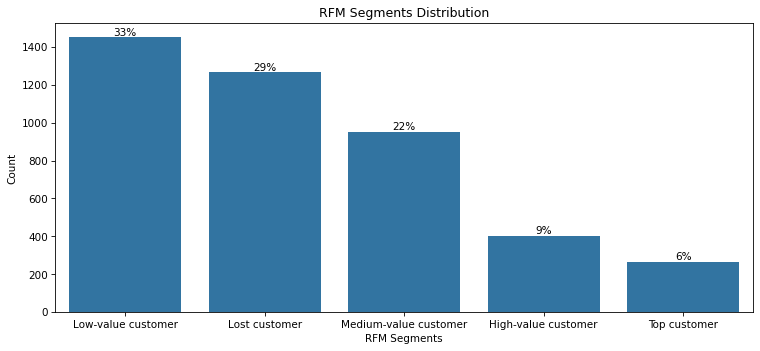

In [20]:
# Visualizing RFM Segments
segment_counts = rfm['RFM_Segment'].value_counts()
segment_pct = (segment_counts / segment_counts.sum()) * 100

plt.figure(figsize=(12, 5))
ax = sns.countplot(data=rfm, x='RFM_Segment', order=segment_counts.index)
for p in ax.patches:
    percentage = '{:.0f}%'.format(100 * p.get_height() / len(rfm))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.title ('RFM Segments Distribution')
plt.xlabel('RFM Segments')
plt.ylabel('Count')
plt.show()

In [21]:
# Appending RFM Segments and scores back to the full dataset
df_rfm = df.merge(rfm[['CustomerID', 'RFM_Segment', 'RFM_Score']], on='CustomerID', how='left')
df_rfm.head()

,InvoiceNo,StockCode,Description,InvoiceDate,CustomerID,Country,Quantity,sales,RFM_Segment,RFM_Score
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01,1785,United Kingdom,6,25.50,Medium-value customer,3.785804
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2010-12-01,1785,United Kingdom,2,15.30,Medium-value customer,3.785804
2,536365,71053,WHITE METAL LANTERN,2010-12-01,1785,United Kingdom,6,20.34,Medium-value customer,3.785804
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01,1785,United Kingdom,6,20.34,Medium-value customer,3.785804
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01,1785,United Kingdom,6,20.34,Medium-value customer,3.785804


## Model Building

### K-Means

In [22]:
# Creating skinny RFM dataframe
rfm_df = rfm[['Recency', 'Frequency', 'Monetary']]

In [23]:
# Scaling with Robust Scaler
scaler = RobustScaler()
scaled_rfm = scaler.fit_transform(rfm_df)
scaled_rfm_df = pd.DataFrame(scaled_rfm, index=rfm.index, columns=rfm_df.columns)

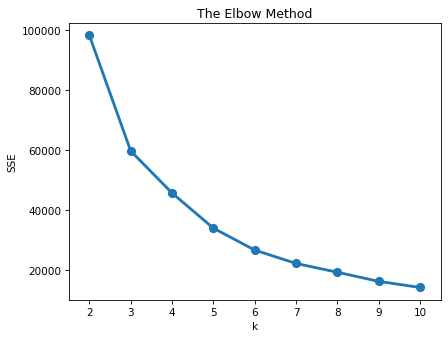

In [24]:
# Visualizing the elbow 
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10)
    kmeans.fit(scaled_rfm_df)
    sse[k] = kmeans.inertia_

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [25]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=1, n_init=10)
    kmeans.fit(scaled_rfm_df)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(scaled_rfm_df, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg.round(5)))

For n_clusters=2, the silhouette score is 0.97768
For n_clusters=3, the silhouette score is 0.94045
For n_clusters=4, the silhouette score is 0.75915
For n_clusters=5, the silhouette score is 0.73927
For n_clusters=6, the silhouette score is 0.70992
For n_clusters=7, the silhouette score is 0.63687
For n_clusters=8, the silhouette score is 0.65403


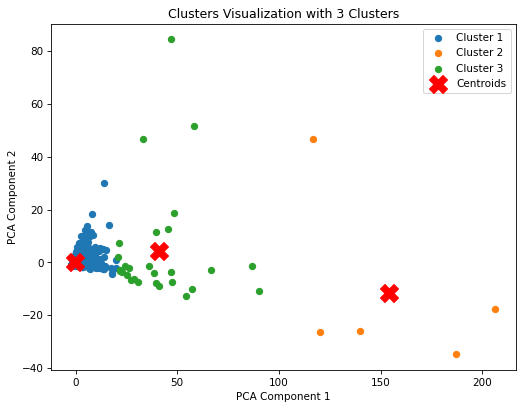

In [26]:
# Function to plot clusters
def plot_clusters(data, cluster_labels, centroids, n_clusters):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    centroid_components = pca.transform(centroids)

    plt.figure(figsize=(8, 6))
    for i in range(n_clusters):
        plt.scatter(principal_components[cluster_labels == i, 0], 
                    principal_components[cluster_labels == i, 1], 
                    label='Cluster ' + str(i + 1))
        
    # Plot centroids
    plt.scatter(centroid_components[:, 0], centroid_components[:, 1], 
                s=300, c='red', label='Centroids', marker='X')
    
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'Clusters Visualization with {n_clusters} Clusters')
    plt.legend()
    plt.show()
    
kmeans = KMeans(n_clusters=3, random_state=1, n_init=10)
kmeans.fit(scaled_rfm_df)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Convert centroids to DataFrame with the same columns as the scaled data
centroids_df = pd.DataFrame(centroids, columns=scaled_rfm_df.columns)

# Plot clusters
plot_clusters(scaled_rfm_df, cluster_labels, centroids_df, 3)

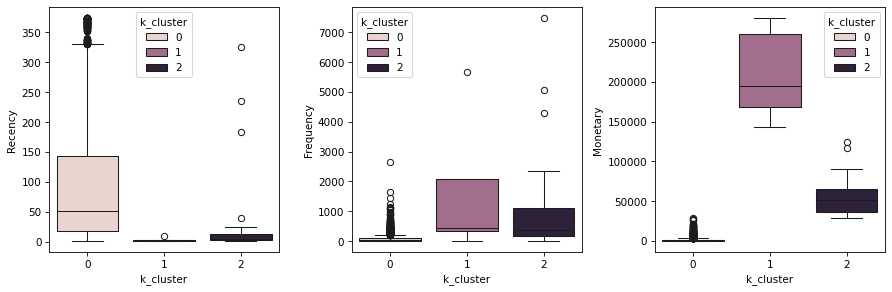

,Recency,Frequency,Monetary
k_cluster,,,
0,93,80,1462
1,3,1704,209287
2,34,1111,55087


In [27]:
# Appending kmeans cluster to rfm dataframe
rfm['k_cluster'] = kmeans.labels_

# Visualizing kmeans clusters
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); sns.boxplot(x='k_cluster', y='Recency', data=rfm, hue='k_cluster')
plt.subplot(1, 3, 2); sns.boxplot(x='k_cluster', y='Frequency', data=rfm, hue='k_cluster')
plt.subplot(1, 3, 3); sns.boxplot(x='k_cluster', y='Monetary', data=rfm, hue='k_cluster')
plt.tight_layout()
plt.show()

# Showing average RFM values for each cluster
cluster_summary = rfm[['Recency', 'Frequency', 'Monetary', 'k_cluster']].groupby('k_cluster').mean()
cluster_summary.astype('int')

### Business Insights and Recommendations
**Cluster 0 - Dormant Customers** represents customers who haven't purchased in a while, as indicated by high recency, make infrequent purchases, and have low monetary value  

These could be churned or inactive customers the company could target with a reactivation campain to re-engage them. The company could better understand these customers through surveys, then offer discounts or special offers. 

**Cluster 1 - VIP Customers** have made very recent purchases and are the most frequent buyers, as well as have the highest monetary value

These are the customers to target with VIP treatment, such as dedicated customer service or exclusive offers, focusing on retention strategies to ensure they continue to feel valued and appreciated. With their high monetary value, these customers could also repond well to cross-selling or upselling techniques to introduce them to complimentary products.

**Cluster 2 - Loyal Customers** includes customers who purchased somewhat recently, make frequent purchases, and have high monetary value  

The company could reward these customers through loyalty programs and offer personalized recommendations based on their purchasing history.

[Back to TOC](#Table-of-Contents)